In [1]:
%load_ext autoreload
%autoreload 2
# Похожий код вы наверняка уже встречали — ставим нужные зависимости, если это колаб
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install torchdiffeq
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

# Main config

In [29]:
ADJOINT = True
SOLVER_METHOD = 'dopri5' #adaptive
TOL = 1e-3



DEVICE_IDS = [0]

# DATASET1, DATASET1_PATH = 'handbag', '../../data/handbag_128.hdf5'
# DATASET2, DATASET2_PATH = 'shoes', '../../data/shoes_128.hdf5'
DATASET1, DATASET1_PATH = 'handbag', '../../data_chizhov/handbag_64.hdf5'
DATASET2, DATASET2_PATH = 'shoes', '../../data_chizhov/shoes_64.hdf5'



# DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
# DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64

BATCH_SIZE = 64

PLOT_INTERVAL = 100
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 2000
MAX_STEPS = 100001
SEED = 0x000000

EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}'
OUTPUT_PATH = 'checkpoints/{}/{}_{}_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE)

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
if ADJOINT:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint as odeint

In [4]:
torch.cuda.is_available()

True

In [4]:
config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2,
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)

assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [6]:
OUTPUT_PATH

'checkpoints/mse/handbag_shoes_64/'

In [6]:
# class ODE_g_func(torch.nn.Module):
#     def __init__(self):
#         return

# func = ODE_g_func()
# odeint(func, y0, t)
# y0=0
# t=0

In [30]:
# generator
# datasets: http://efrosgans.eecs.berkeley.edu/iGAN/datasets/handbag_64.zip
# datasets: http://efrosgans.eecs.berkeley.edu/iGAN/datasets/sketch_shoes_64.zip
# datasets: http://efrosgans.eecs.berkeley.edu/iGAN/datasets/shoes_64.zip
# implementation from  https://github.com/rtqichen/torchdiffeq/blob/master/examples/odenet_mnist.py
from utils.unet import UNet_func



class ODEBlock(nn.Module):

    def __init__(self, odefunc, method=SOLVER_METHOD, tol=TOL):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()
        self.tol = tol
        self.method = method

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time,
                     method=self.method, rtol=self.tol, atol=self.tol)
        return out[1]
    
    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value



In [31]:
# descriminator
class ResNet_D(nn.Module):
    "Discriminator ResNet architecture from https://github.com/harryliew/WGAN-QC"
    def __init__(self, size=64, nc=3, nfilter=64, nfilter_max=512, res_ratio=0.1):
        super().__init__()
        s0 = self.s0 = 4
        nf = self.nf = nfilter
        nf_max = self.nf_max = nfilter_max
        self.nc = nc

        # Submodules
        nlayers = int(np.log2(size / s0))
        self.nf0 = min(nf_max, nf * 2**nlayers)

        nf0 = min(nf, nf_max)
        nf1 = min(nf * 2, nf_max)
        blocks = [
            ResNetBlock(nf0, nf0, bn=False, res_ratio=res_ratio),
            ResNetBlock(nf0, nf1, bn=False, res_ratio=res_ratio)
        ]

        for i in range(1, nlayers+1):
            nf0 = min(nf * 2**i, nf_max)
            nf1 = min(nf * 2**(i+1), nf_max)
            blocks += [
                nn.AvgPool2d(3, stride=2, padding=1),
                ResNetBlock(nf0, nf0, bn=False, res_ratio=res_ratio),
                ResNetBlock(nf0, nf1, bn=False, res_ratio=res_ratio),
            ]

        self.conv_img = nn.Conv2d(nc, 1*nf, 3, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.resnet = nn.Sequential(*blocks)
        self.fc = nn.Linear(self.nf0*s0*s0, 1)

    def forward(self, x):
        batch_size = x.size(0)

        out = self.relu((self.conv_img(x)))
        out = self.resnet(out)
        out = out.view(batch_size, self.nf0*self.s0*self.s0)
        out = self.fc(out)

        return out


class ResNetBlock(nn.Module):
    def __init__(self, fin, fout, fhidden=None, bn=True, res_ratio=0.1):
        super().__init__()
        # Attributes
        self.bn = bn
        self.is_bias = not bn
        self.learned_shortcut = (fin != fout)
        self.fin = fin
        self.fout = fout
        if fhidden is None:
            self.fhidden = min(fin, fout)
        else:
            self.fhidden = fhidden
        self.res_ratio = res_ratio

        # Submodules
        self.conv_0 = nn.Conv2d(self.fin, self.fhidden, 3, stride=1, padding=1, bias=self.is_bias)
        if self.bn:
            self.bn2d_0 = nn.BatchNorm2d(self.fhidden)
        self.conv_1 = nn.Conv2d(self.fhidden, self.fout, 3, stride=1, padding=1, bias=self.is_bias)
        if self.bn:
            self.bn2d_1 = nn.BatchNorm2d(self.fout)
        if self.learned_shortcut:
            self.conv_s = nn.Conv2d(self.fin, self.fout, 1, stride=1, padding=0, bias=False)
            if self.bn:
                self.bn2d_s = nn.BatchNorm2d(self.fout)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x_s = self._shortcut(x)
        dx = self.conv_0(x)
        if self.bn:
            dx = self.bn2d_0(dx)
        dx = self.relu(dx)
        dx = self.conv_1(dx)
        if self.bn:
            dx = self.bn2d_1(dx)
        out = self.relu(x_s + self.res_ratio*dx)
        return out

    def _shortcut(self, x):
        if self.learned_shortcut:
            x_s = self.conv_s(x)
            if self.bn:
                x_s = self.bn2d_s(x_s)
        else:
            x_s = x
        return x_s


In [32]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

import torch.nn.functional as F

from src_not.resnet2 import ResNet_D
from src_not import distributions
# from src.unet import UNet

from src_not.tools import unfreeze, freeze
from src_not.tools import weights_init_D
from src_not.tools import load_dataset, get_pushed_loader_stats
from src_not.fid_score import calculate_frechet_distance
from src_not.plotters import plot_random_images, plot_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src_not.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

In [ ]:
# ../NeuralOptimalTransport/stats/handbag_64_test.json

In [33]:
filename = '../NeuralOptimalTransport/stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

In [15]:
len(sigma_data)

2048

In [14]:
len(mu_data)

2048

In [16]:
X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE)
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)
    
torch.cuda.empty_cache(); gc.collect()

Keys: <KeysViewHDF5 ['imgs']>
Keys: <KeysViewHDF5 ['imgs']>


43

init networks

In [52]:
from utils.unet import UNet_func
ode_f = UNet_func(3, 3, base_factor=48).cuda()
T = ODEBlock(ode_f).cuda()
f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

# T = UNet(3, 3, base_factor=48).cuda()

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 15037926
f params: 22933441


In [38]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)
X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

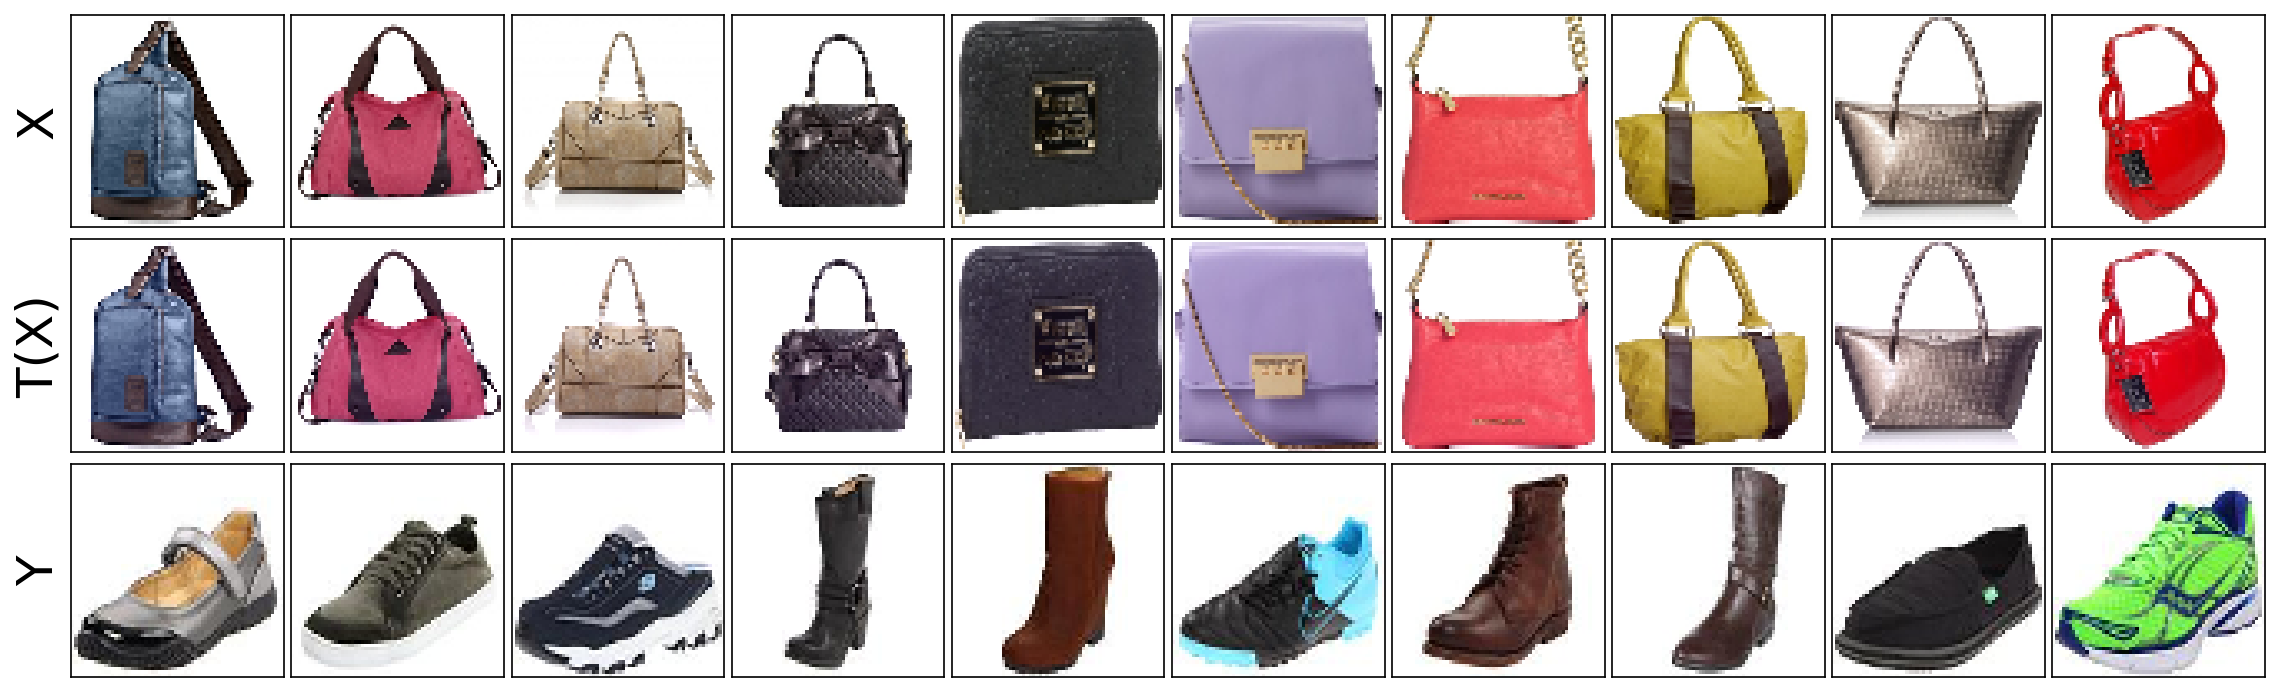

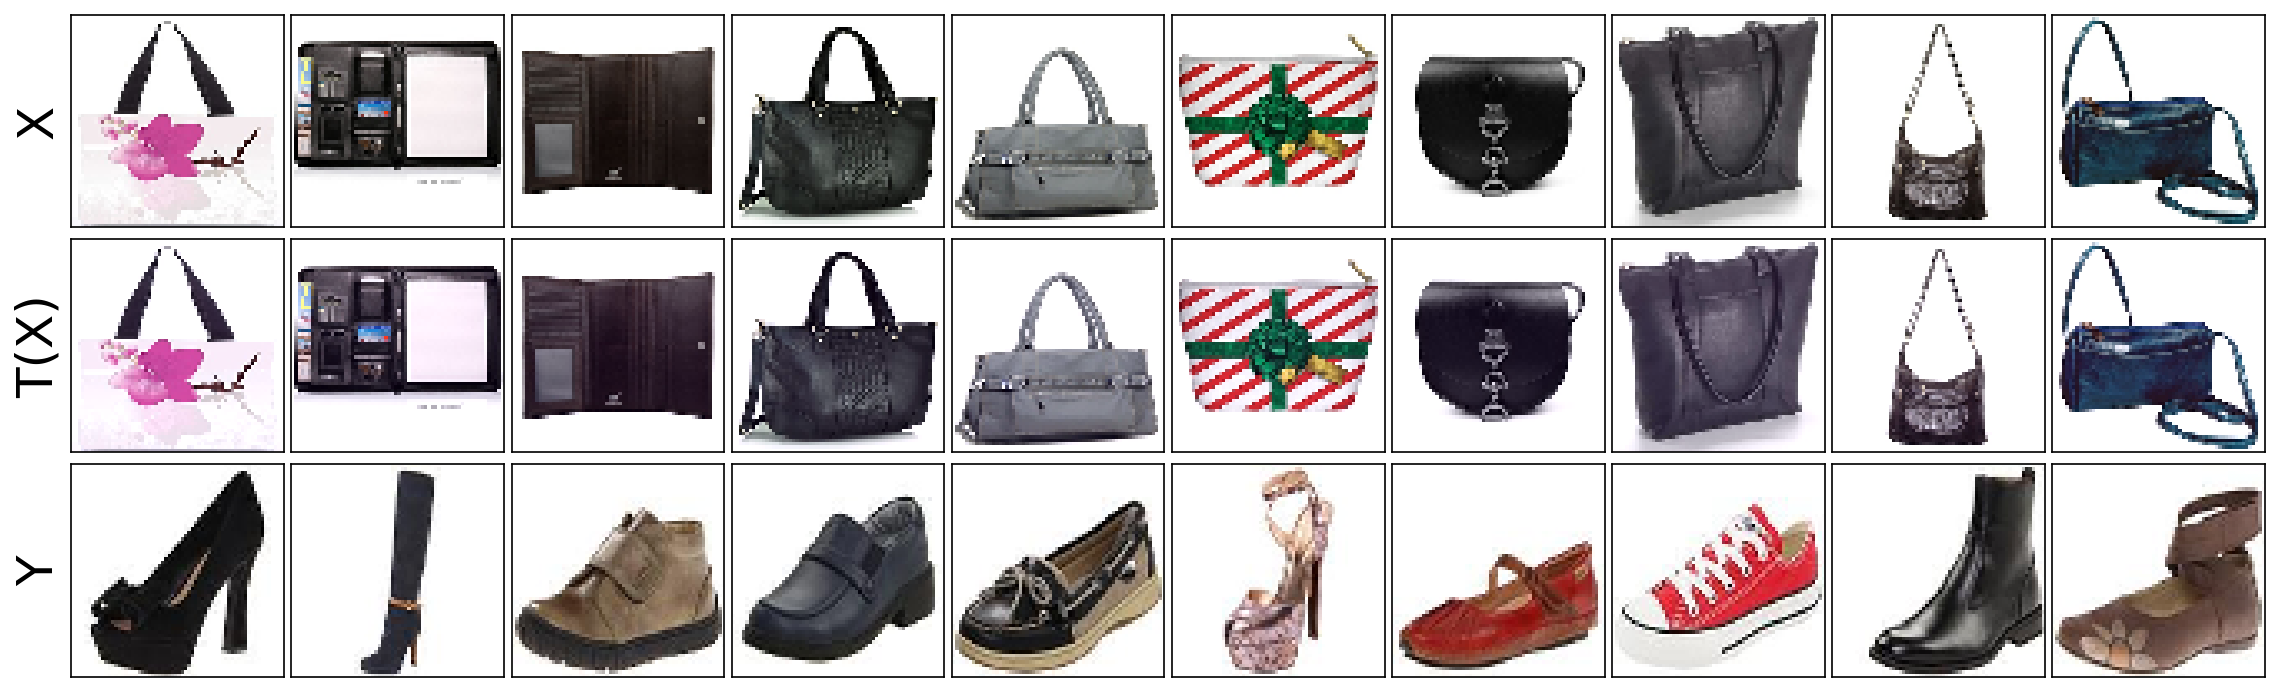

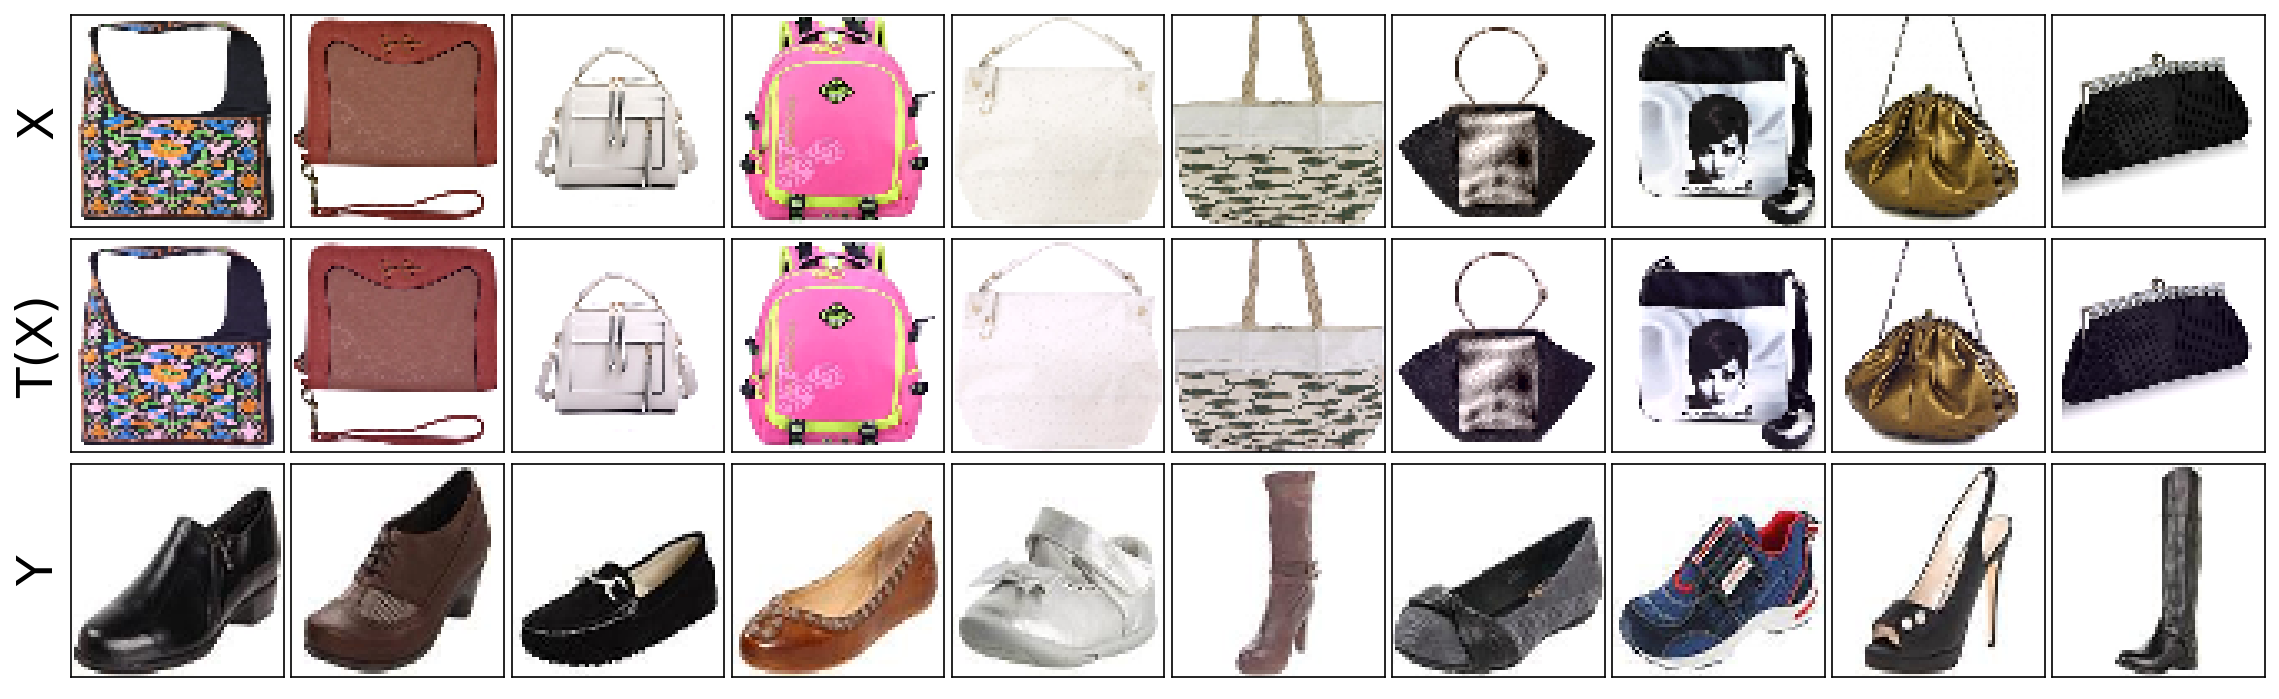

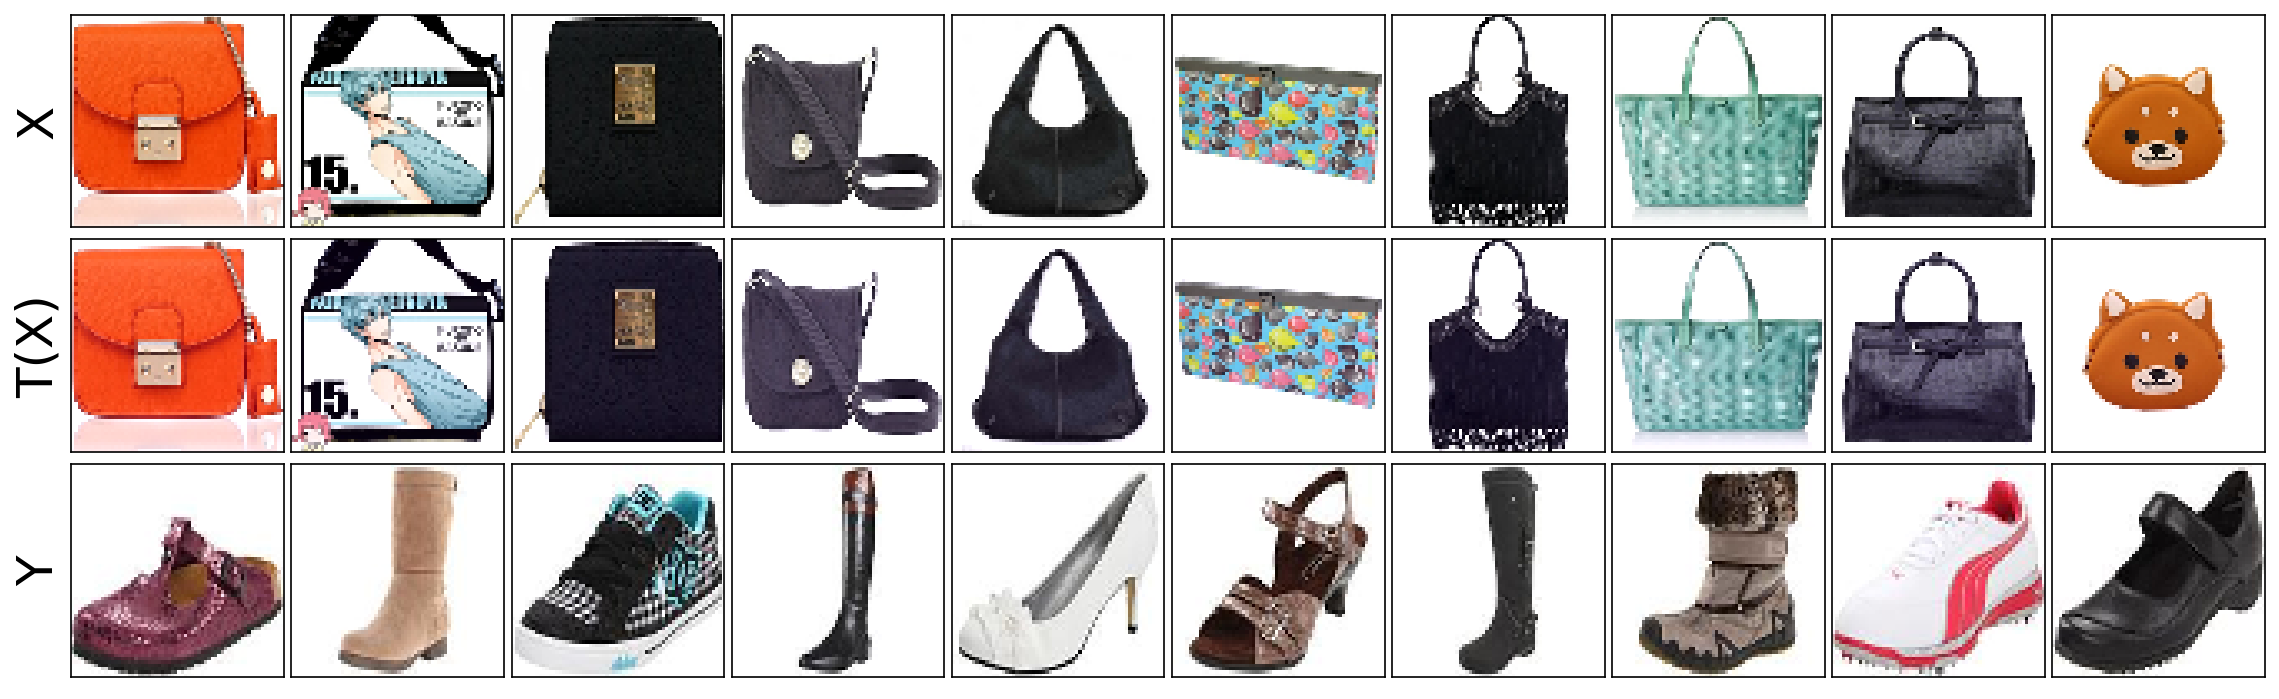

In [39]:
fig, axes = plot_images(X_fixed, Y_fixed, T)
fig, axes = plot_random_images(X_sampler, Y_sampler, T)
fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)

In [40]:
wandb.init(name=EXP_NAME, project='ode_strong_not', config=config)


wandb: Currently logged in as: peter_chizhov. Use `wandb login --relogin` to force relogin


In [53]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

In [54]:
import time

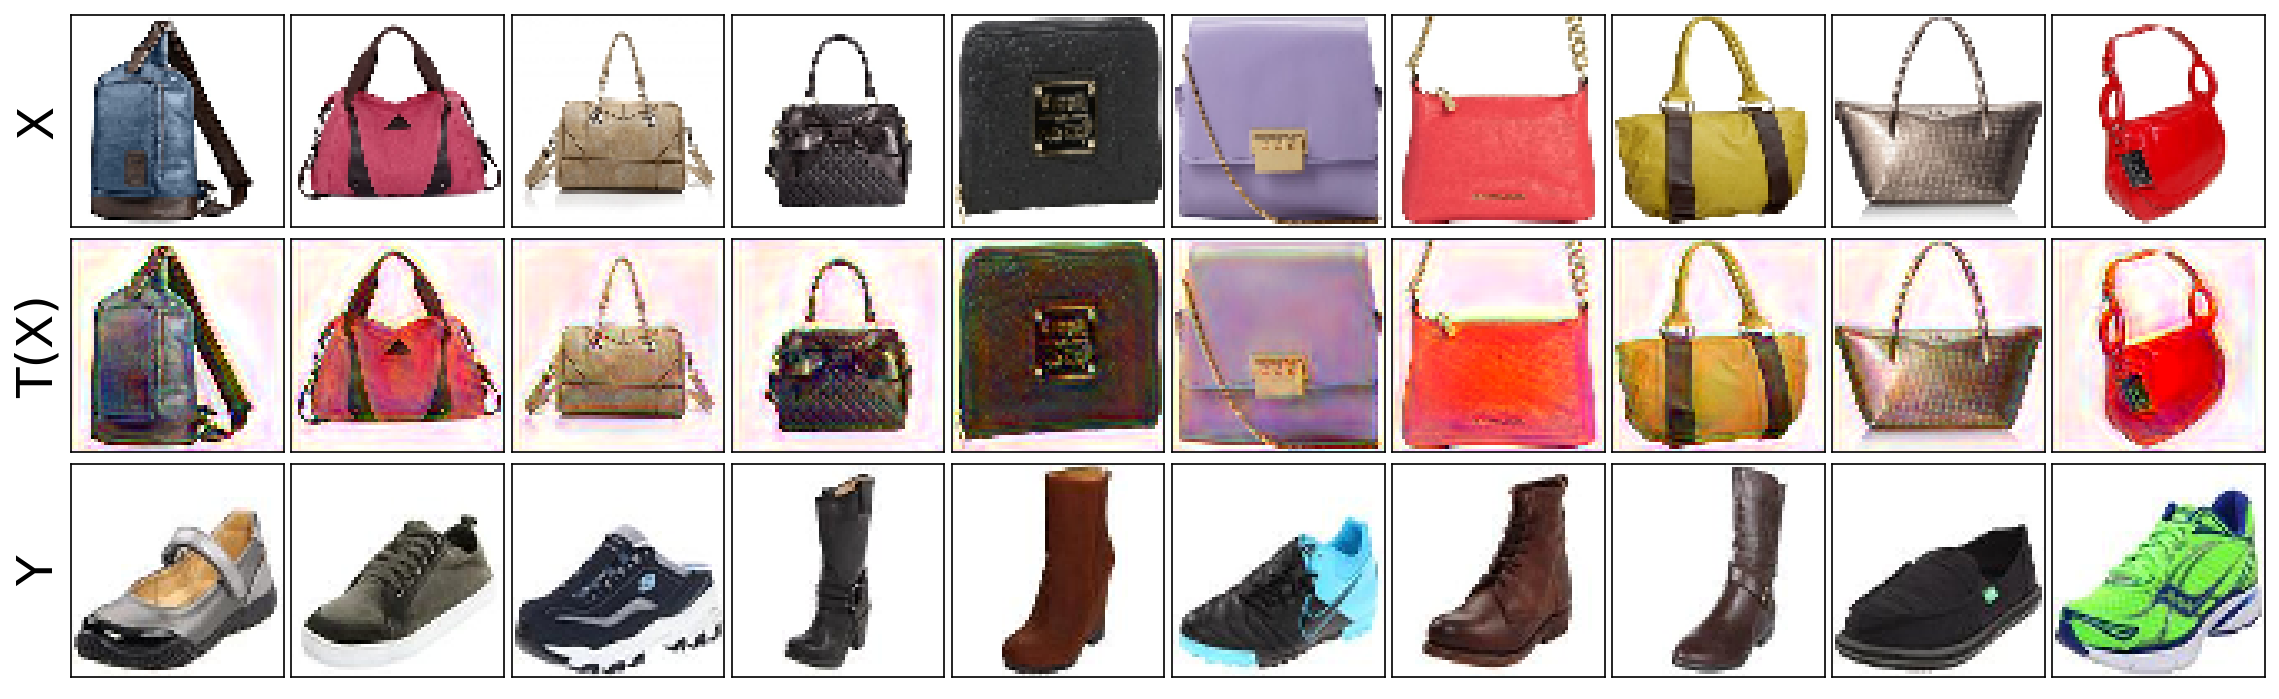

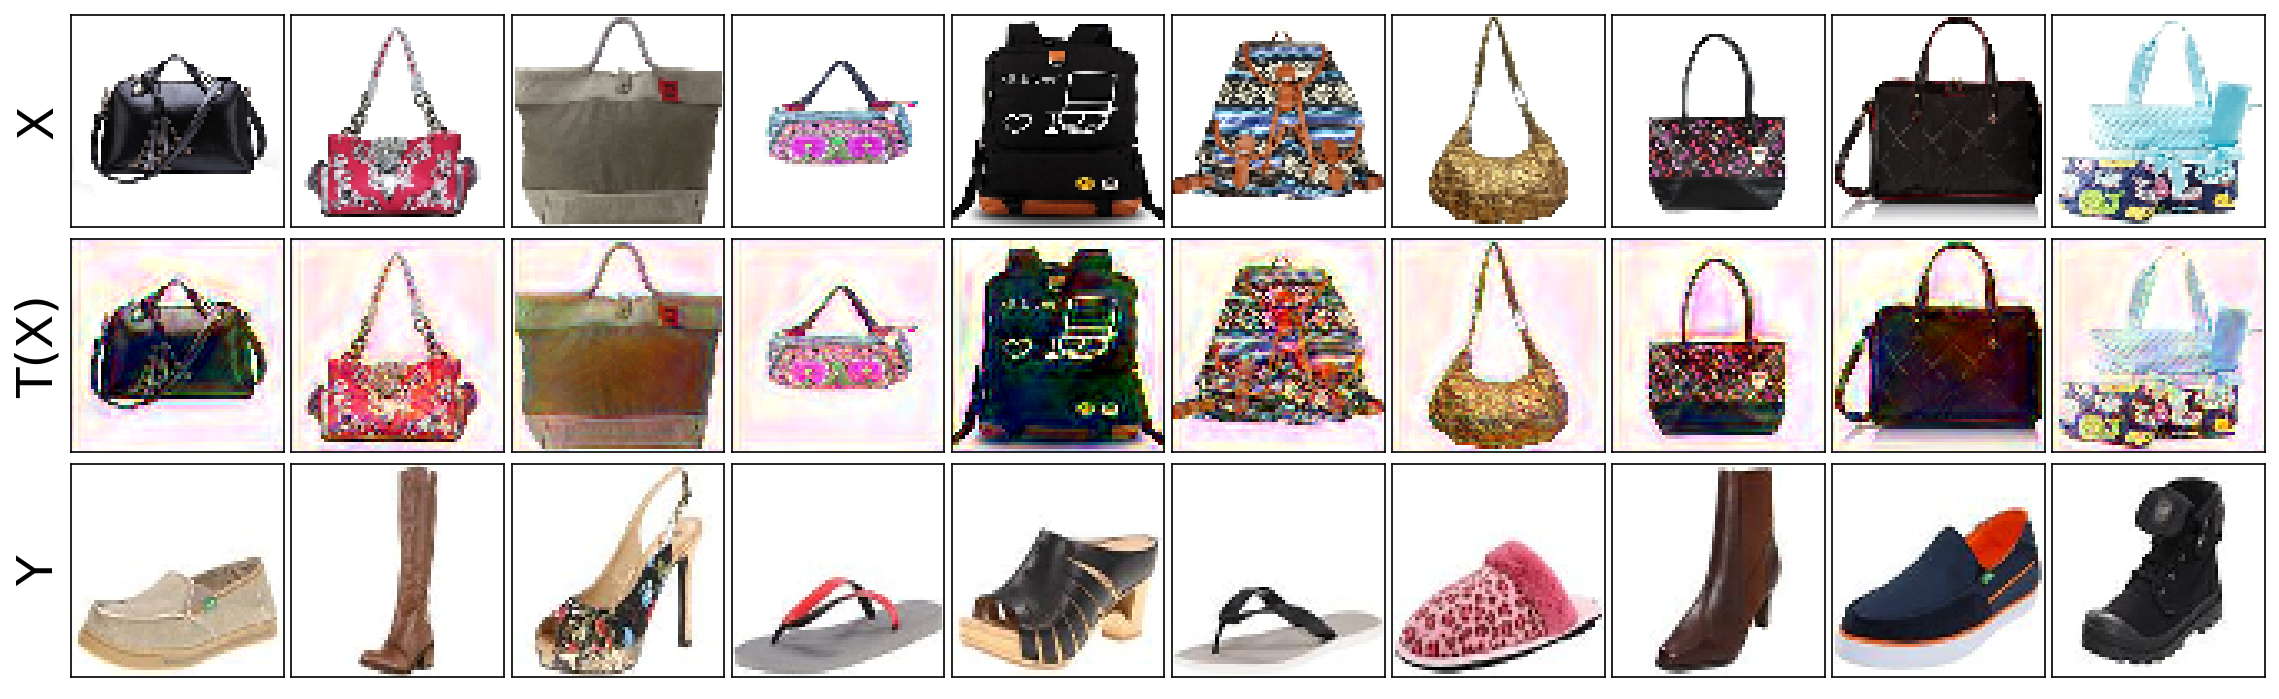

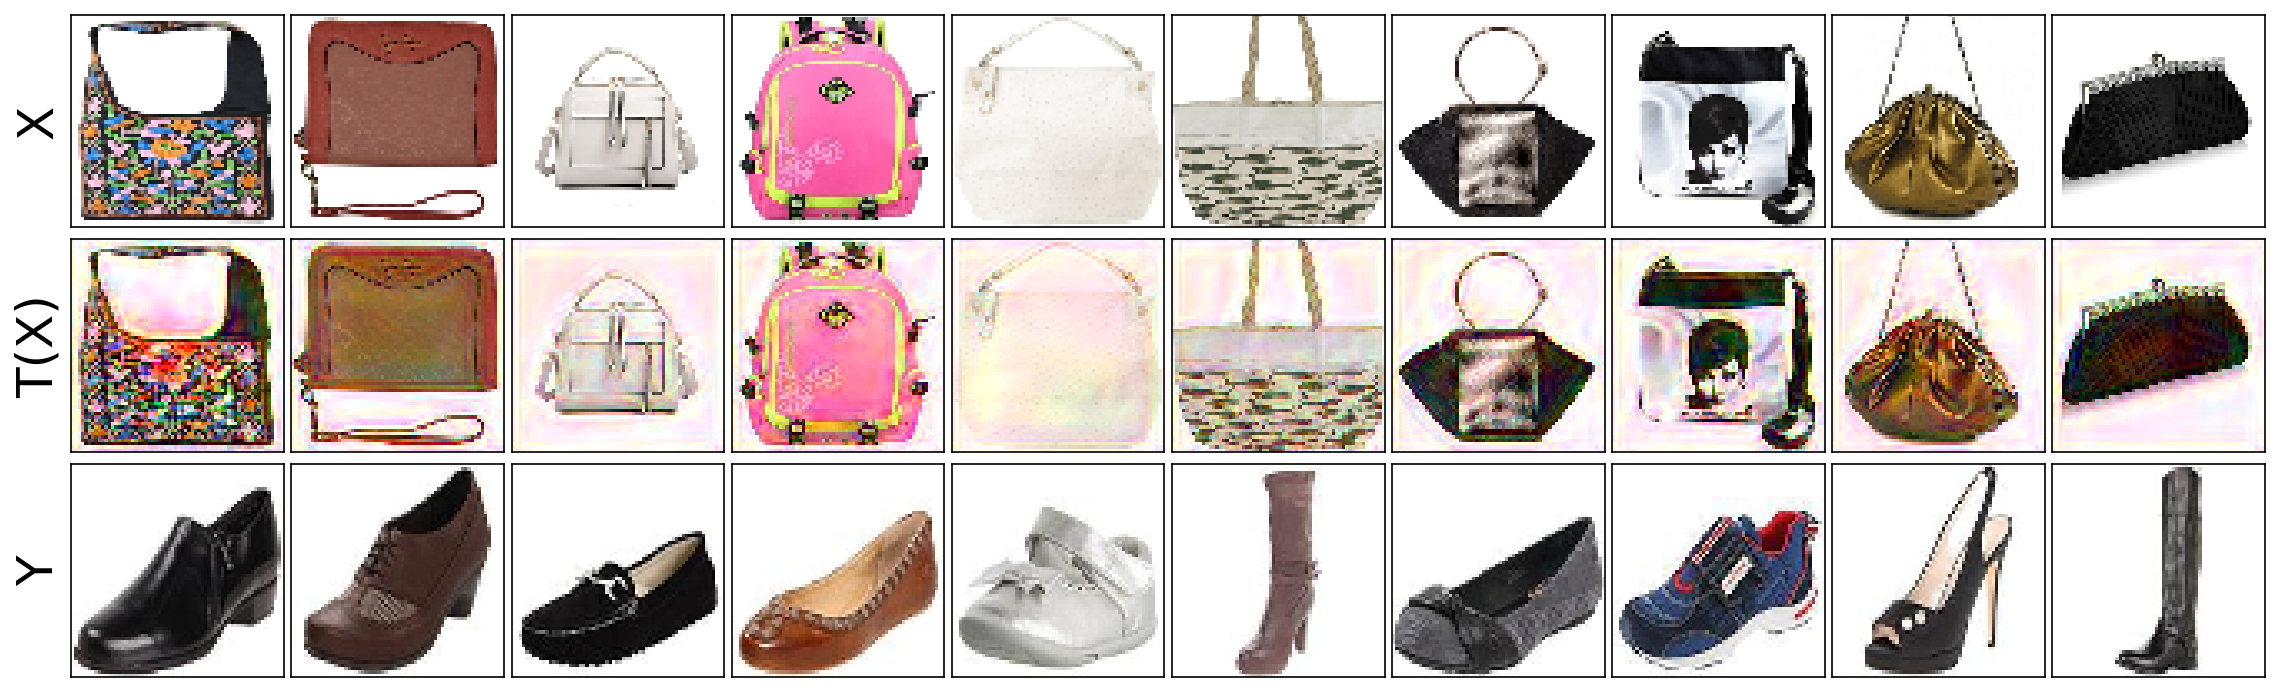

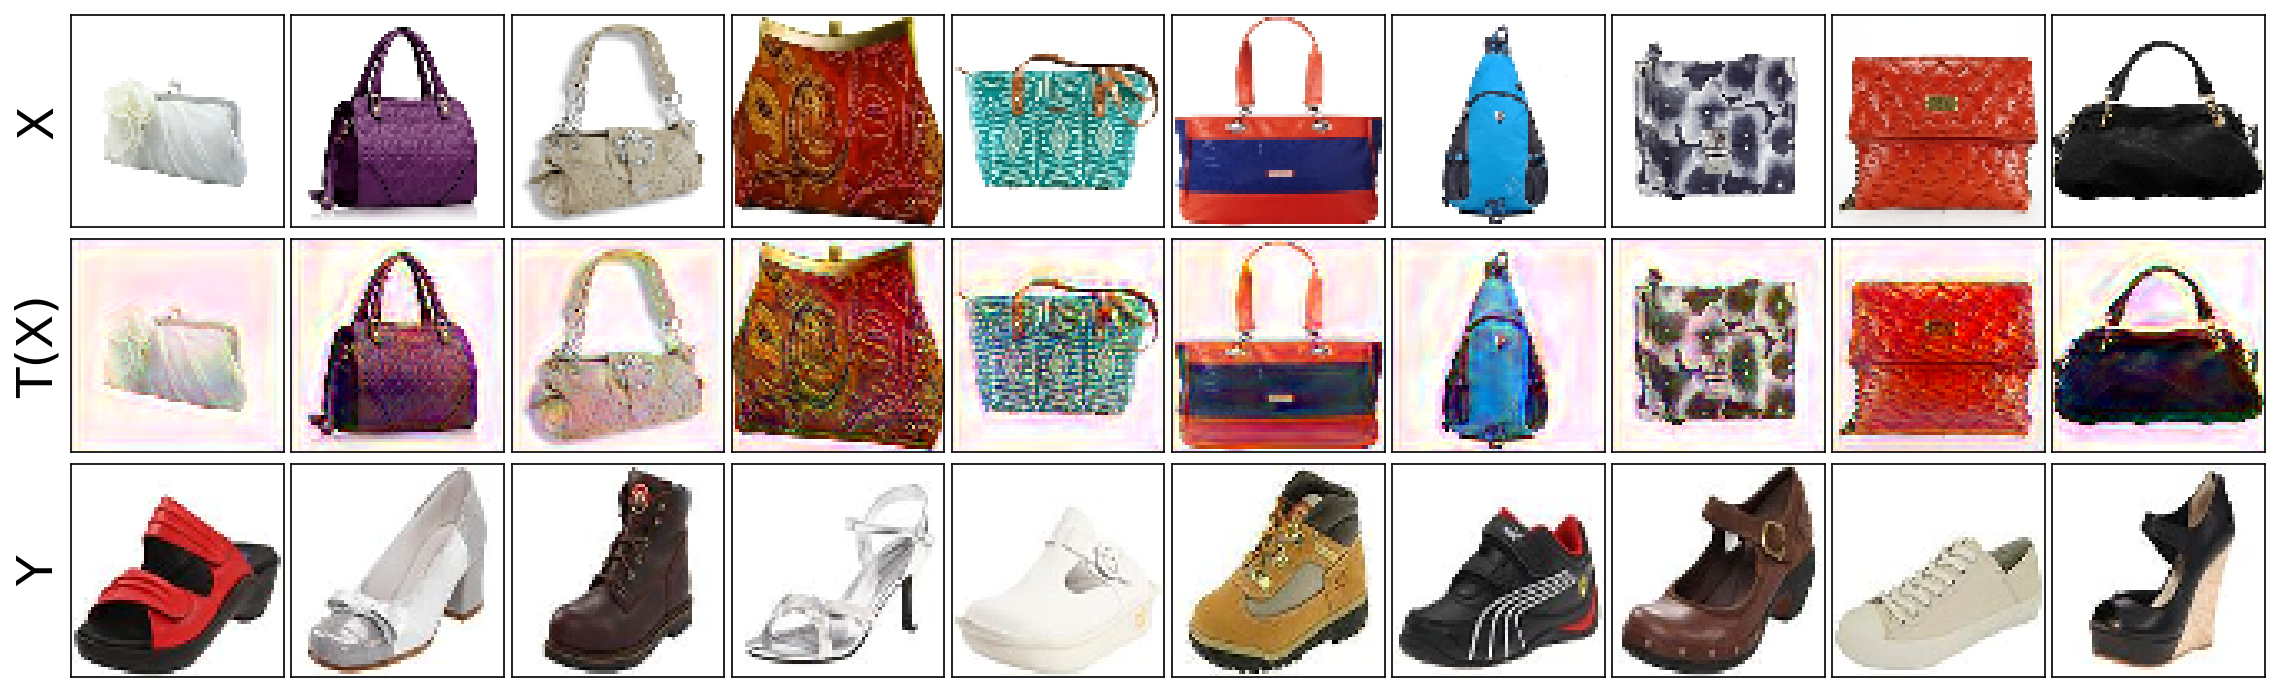

In [ ]:
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    avg_gen_opt_step_time = 0
    avg_num_func_eval_per_opt_step = 0
    for t_iter in range(T_ITERS):
        generator_opt_step_time = time.time()
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        T_X = T(X)
        if COST == 'mse':
            T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
        else:
            raise Exception('Unknown COST')
            
        with torch.no_grad():
            num_func_eval = T.nfe
        T_loss.backward(); T_opt.step()
        with torch.no_grad():
            num_func_eval_per_opt_step = T.nfe - num_func_eval
        
        generator_opt_step_time = time.time() - generator_opt_step_time
        avg_gen_opt_step_time += generator_opt_step_time
        avg_num_func_eval_per_opt_step += num_func_eval_per_opt_step
        
    avg_gen_opt_step_time /= T_ITERS 
    avg_num_func_eval_per_opt_step /= T_ITERS
    # del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    discriminator_opt_step_time = time.time()
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        T_X = T(X)
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    f_loss = f(T_X).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    discriminator_opt_step_time = time.time() - discriminator_opt_step_time
    wandb.log({'f_loss' : f_loss.item(),
               'T_loss' : T_loss.item(),
              'avg_num_func_eval_per_opt_step' : avg_num_func_eval_per_opt_step,
              'avg_gen_opt_step_time' : avg_gen_opt_step_time,
              'discriminator_opt_step_time' : discriminator_opt_step_time
              }, step=step) 
    # del f_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_images(X_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
    
    if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
        freeze(T); 
        
        print('Computing FID')
        mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({f'FID (Test)' : fid}, step=step)
        # del mu, sigma
        
        torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
#         torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
#         torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
#         torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))
    
    # gc.collect(); torch.cuda.empty_cache()

### distribution.py

In [9]:
# distribution.py
import torch
import numpy as np
import random
from scipy.linalg import sqrtm
from sklearn import datasets

class Sampler:
    def __init__(
        self, device='cuda',
    ):
        self.device = device

    def sample(self, size=5):
        pass

class LoaderSampler(Sampler):
    def __init__(self, loader, device='cuda'):
        super(LoaderSampler, self).__init__(device)
        self.loader = loader
        self.it = iter(self.loader)

    def sample(self, size=5):
        assert size <= self.loader.batch_size
        try:
            batch, _ = next(self.it)
        except StopIteration:
            self.it = iter(self.loader)
            return self.sample(size)
        if len(batch) < size:
            return self.sample(size)

        return batch[:size].to(self.device)


class SwissRollSampler(Sampler):
    def __init__(
        self, dim=2, device='cuda'
    ):
        super(SwissRollSampler, self).__init__(device=device)
        assert dim == 2
        self.dim = 2

    def sample(self, batch_size=10):
        batch = datasets.make_swiss_roll(
            n_samples=batch_size,
            noise=0.8
        )[0].astype('float32')[:, [0, 2]] / 7.5
        return torch.tensor(batch, device=self.device)

class StandardNormalSampler(Sampler):
    def __init__(self, dim=1, device='cuda'):
        super(StandardNormalSampler, self).__init__(device=device)
        self.dim = dim

    def sample(self, batch_size=10):
        return torch.randn(batch_size, self.dim, device=self.device)


class Mix8GaussiansSampler(Sampler):
    def __init__(self, with_central=False, std=1, r=12, dim=2, device='cuda'):
        super(Mix8GaussiansSampler, self).__init__(device=device)
        assert dim == 2
        self.dim = 2
        self.std, self.r = std, r

        self.with_central = with_central
        centers = [
            (1, 0), (-1, 0), (0, 1), (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        if self.with_central:
            centers.append((0, 0))
        self.centers = torch.tensor(centers, device=self.device, dtype=torch.float32)

    def sample(self, batch_size=10):
        with torch.no_grad():
            batch = torch.randn(batch_size, self.dim, device=self.device)
            indices = random.choices(range(len(self.centers)), k=batch_size)
            batch *= self.std
            batch += self.r * self.centers[indices, :]
        return batch


class MixNGaussiansSampler(Sampler):
    def __init__(self, n=5, dim=2, std=1, step=9, device='cuda'):
        super(MixNGaussiansSampler, self).__init__(device=device)

        assert dim == 1
        self.dim = 1
        self.std, self.step = std, step

        self.n = n

        grid_1d = np.linspace(-(n-1) / 2., (n-1) / 2., n)
        self.centers = torch.tensor(grid_1d, device=self.device,)

    def sample(self, batch_size=10):
        batch = torch.randn(batch_size, self.dim, device=self.device)
        indices = random.choices(range(len(self.centers)), k=batch_size)
        with torch.no_grad():
            batch *= self.std
            batch += self.step * self.centers[indices, None]
        return batch


class Transformer(object):
    def __init__(self, device='cuda'):
        self.device = device


class StandardNormalScaler(Transformer):
    def __init__(self, base_sampler, batch_size=1000, device='cuda'):
        super(StandardNormalScaler, self).__init__(device=device)
        self.base_sampler = base_sampler
        batch = self.base_sampler.sample(batch_size).cpu().detach().numpy()

        mean, cov = np.mean(batch, axis=0), np.matrix(np.cov(batch.T))

        self.mean = torch.tensor(
            mean, device=self.device, dtype=torch.float32
        )

        multiplier = sqrtm(cov)
        self.multiplier = torch.tensor(
            multiplier, device=self.device, dtype=torch.float32
        )
        self.inv_multiplier = torch.tensor(
            np.linalg.inv(multiplier),
            device=self.device, dtype=torch.float32
        )
        torch.cuda.empty_cache()

    def sample(self, batch_size=10):
        with torch.no_grad():
            batch = torch.tensor(self.base_sampler.sample(batch_size), device=self.device)
            batch -= self.mean
            batch @= self.inv_multiplier
        return batch

### tools.py

In [10]:
import pandas as pd
import numpy as np

import os
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm_notebook
import multiprocessing

from PIL import Image
# from .inception import InceptionV3
from tqdm import tqdm_notebook as tqdm
# from .fid_score import calculate_frechet_distance
# from .distributions import LoaderSampler
import h5py
from torch.utils.data import TensorDataset

import gc

from torch.utils.data import Subset, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor, RandomCrop
from torchvision.datasets import ImageFolder


def load_dataset(name, path, img_size=64, batch_size=64, test_ratio=0.1, device='cuda'):
    if name in ['shoes', 'handbag', 'outdoor', 'church']:
        dataset = h5py_to_dataset(path, img_size)
    elif name in ['celeba_female', 'celeba_male', 'aligned_anime_faces', 'describable_textures']:
        transform = Compose([Resize((img_size, img_size)), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        dataset = ImageFolder(path, transform=transform)
    else:
        raise Exception('Unknown dataset')

    if name in ['celeba_female', 'celeba_male']:
        with open('../datasets/list_attr_celeba.txt', 'r') as f:
            lines = f.readlines()[2:]
        if name == 'celeba_female':
            idx = [i for i in list(range(len(lines))) if lines[i].replace('  ', ' ').split(' ')[21] == '-1']
        else:
            idx = [i for i in list(range(len(lines))) if lines[i].replace('  ', ' ').split(' ')[21] != '-1']
    elif dataset == 'describable_textures':
        idx = np.random.RandomState(seed=0xBADBEEF).permutation(len(dataset))
    else:
        idx = list(range(len(dataset)))

    test_size = int(len(idx) * test_ratio)
    train_idx, test_idx = idx[:-test_size], idx[-test_size:]
    train_set, test_set = Subset(dataset, train_idx), Subset(dataset, test_idx)

    train_sampler = LoaderSampler(DataLoader(train_set, shuffle=True, num_workers=8, batch_size=batch_size), device)
    test_sampler = LoaderSampler(DataLoader(test_set, shuffle=True, num_workers=8, batch_size=batch_size), device)
    return train_sampler, test_sampler

def ewma(x, span=200):
    return pd.DataFrame({'x': x}).ewm(span=span).mean().values[:, 0]

def freeze(model):
    for p in model.parameters():
        p.requires_grad_(False)
    model.eval()

def unfreeze(model):
    for p in model.parameters():
        p.requires_grad_(True)
    model.train(True)

def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )

    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )

    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

def fig2img ( fig ):
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

def h5py_to_dataset(path, img_size=64):
    with h5py.File(path, "r") as f:
        # List all groups
        print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())[0]

        # Get the data
        data = list(f[a_group_key])
    with torch.no_grad():
        dataset = 2 * (torch.tensor(np.array(data), dtype=torch.float32) / 255.).permute(0, 3, 1, 2) - 1
        dataset = F.interpolate(dataset, img_size, mode='bilinear')

    return TensorDataset(dataset, torch.zeros(len(dataset)))

def get_loader_stats(loader, batch_size=8, verbose=False):
    dims = 2048
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).cuda()
    freeze(model)

    size = len(loader.dataset)
    pred_arr = []

    with torch.no_grad():
        for step, (X, _) in enumerate(loader) if not verbose else tqdm(enumerate(loader)):
            for i in range(0, len(X), batch_size):
                start, end = i, min(i + batch_size, len(X))
                batch = ((X[start:end] + 1) / 2).type(torch.FloatTensor).cuda()
                pred_arr.append(model(batch)[0].cpu().data.numpy().reshape(end-start, -1))

    pred_arr = np.vstack(pred_arr)
    mu, sigma = np.mean(pred_arr, axis=0), np.cov(pred_arr, rowvar=False)
    gc.collect(); torch.cuda.empty_cache()
    return mu, sigma

def get_pushed_loader_stats(T, loader, batch_size=8, verbose=False, device='cuda',
                            use_downloaded_weights=False):
    dims = 2048
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx], use_downloaded_weights=use_downloaded_weights).to(device)
    freeze(model); freeze(T)

    size = len(loader.dataset)
    pred_arr = []

    with torch.no_grad():
        for step, (X, _) in enumerate(loader) if not verbose else tqdm(enumerate(loader)):
            for i in range(0, len(X), batch_size):
                start, end = i, min(i + batch_size, len(X))
                batch = T(X[start:end].type(torch.FloatTensor).to(device)).add(1).mul(.5)
                pred_arr.append(model(batch)[0].cpu().data.numpy().reshape(end-start, -1))

    pred_arr = np.vstack(pred_arr)
    mu, sigma = np.mean(pred_arr, axis=0), np.cov(pred_arr, rowvar=False)
    gc.collect(); torch.cuda.empty_cache()
    return mu, sigma

def get_Z_pushed_loader_stats(T, loader, ZC=1, Z_STD=0.1, batch_size=8, verbose=False,
                              device='cuda',
                              use_downloaded_weights=False):
    dims = 2048
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx], use_downloaded_weights=use_downloaded_weights).to(device)
    freeze(model); freeze(T)

    size = len(loader.dataset)
    pred_arr = []

    with torch.no_grad():
        for step, (X, _) in enumerate(loader) if not verbose else tqdm(enumerate(loader)):
            Z = torch.randn(len(X), ZC, X.size(2), X.size(3)) * Z_STD
            XZ = torch.cat([X,Z], dim=1)
            for i in range(0, len(X), batch_size):
                start, end = i, min(i + batch_size, len(X))
                batch = T(XZ[start:end].type(torch.FloatTensor).to(device)).add(1).mul(.5)
                pred_arr.append(model(batch)[0].cpu().data.numpy().reshape(end-start, -1))

    pred_arr = np.vstack(pred_arr)
    mu, sigma = np.mean(pred_arr, axis=0), np.cov(pred_arr, rowvar=False)
    gc.collect(); torch.cuda.empty_cache()
    return mu, sigma